In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
# from numpy import arange
# from numpy import meshgrid
import numpy as np

from box_utils import prepare_boxes_plot, mul_intervals, pow_interval, neg_interval, subtr_intervals
from boxapprox import box_parallel
# %matplotlib qt5

**Использование алгоритма для 5-звенника**

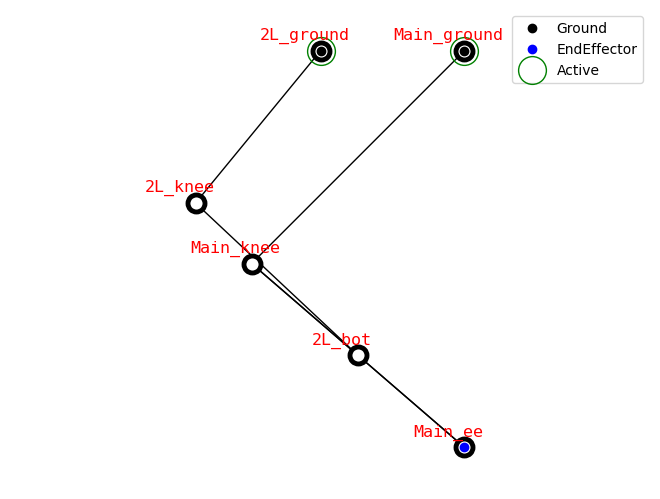

In [2]:
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator
from auto_robot_design.description.utils import draw_joint_point

gen = TwoLinkGenerator()
# builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE)
graphs_and_cons = gen.get_standard_set()
np.set_printoptions(precision=3, linewidth=300, suppress=True, threshold=10000)

graph, __ = graphs_and_cons[0]
# robo, robo_free = jps_graph2pinocchio_robot(graph, builder)



draw_joint_point(graph)

In [3]:
from auto_robot_design.description.mechanism import JointPoint2KinematicGraph
from auto_robot_design.description.utils import draw_links

kinematic_graph = JointPoint2KinematicGraph(graph)
# draw_links(kinematic_graph, graph)
from auto_robot_design.description.utils import draw_kinematic_graph
# draw_kinematic_graph(kinematic_graph)
main_branch = kinematic_graph.define_main_branch()
# draw_kinematic_graph(main_branch)
kin_tree = kinematic_graph.define_span_tree()
# draw_kinematic_graph(kin_tree)


In [4]:
# for n in robo.model.names:
#     print(n)
# for k,frame in enumerate(robo.model.frames):
#     print("frame {}: {}".format(k,frame.name))

# EFFECTOR_NAME = "EE"
# BASE_FRAME = "G"
# LINK_FRAMES = ['L6','L5','L3','L4'] # ee is last

G (array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([0., 0., 0.]))
L3 (array([[-0.707, -0.   , -0.707],
       [ 0.   ,  1.   , -0.   ],
       [ 0.707,  0.   , -0.707]]), array([0., 0., 0.]))
L4 (array([[-0.653,  0.   ,  0.757],
       [ 0.   ,  1.   ,  0.   ],
       [-0.757,  0.   , -0.653]]), array([-0.148,  0.   , -0.148]))
EE (array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([ 0.   ,  0.   , -0.276]))
L6 (array([[-0.773, -0.   , -0.635],
       [ 0.   ,  1.   , -0.   ],
       [ 0.635,  0.   , -0.773]]), array([-0.1,  0. ,  0. ]))
L5 (array([[-0.684,  0.   ,  0.73 ],
       [ 0.   ,  1.   ,  0.   ],
       [-0.73 ,  0.   , -0.684]]), array([-0.187,  0.   , -0.106]))


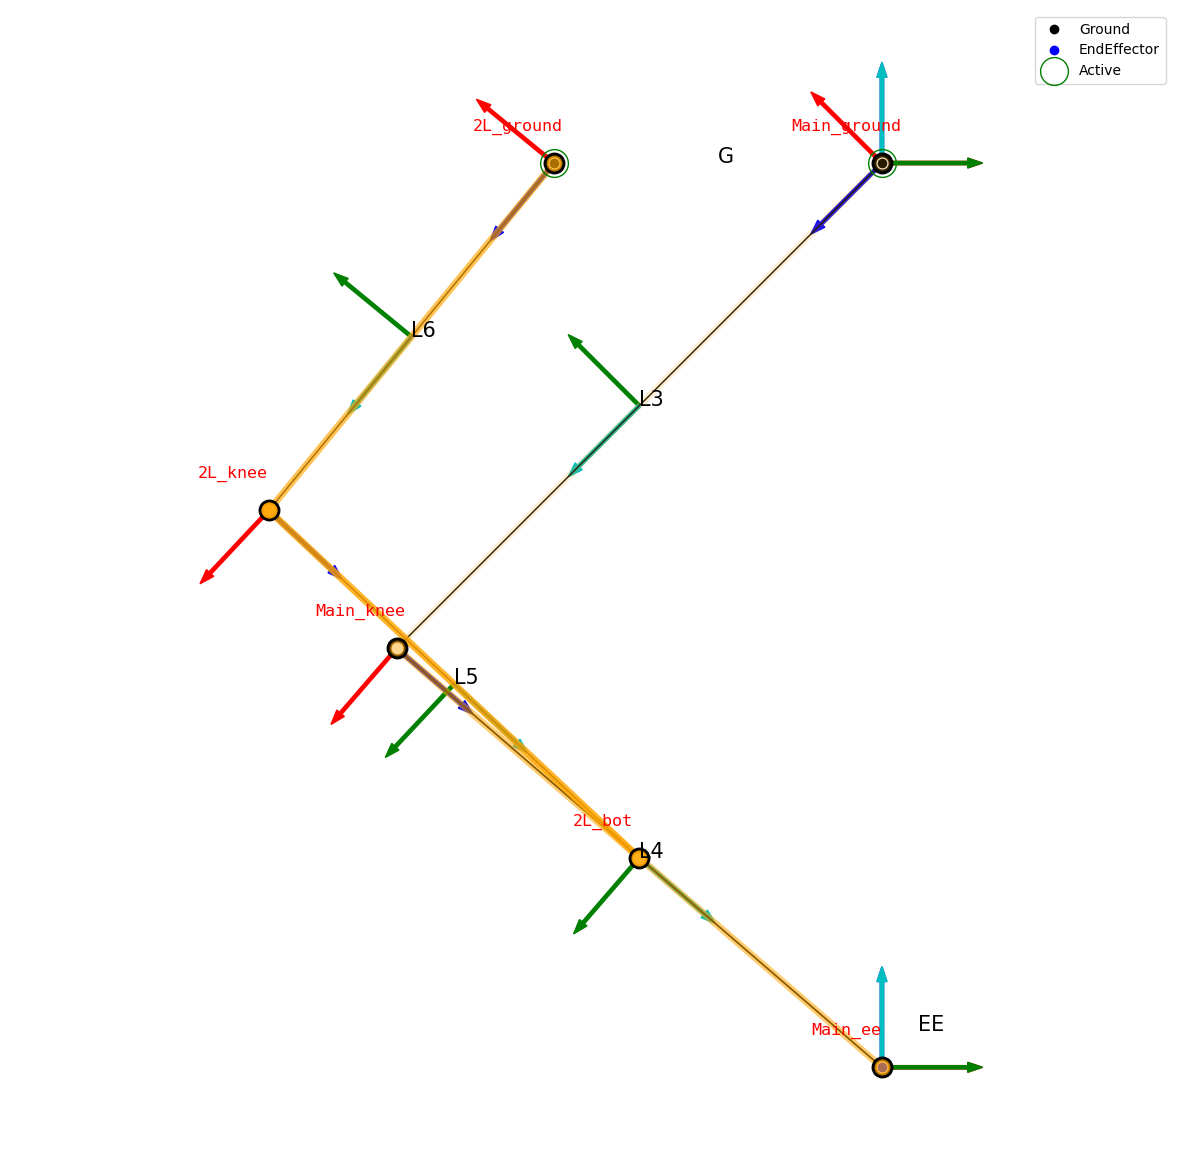

In [5]:
import modern_robotics as mr
from auto_robot_design.description.utils import draw_link_frames
from auto_robot_design.description.actuators import TMotor_AK80_9

thickness = 0.04
density = 2700 / 2.8

for n in kinematic_graph.nodes():
    n.thickness = thickness
    n.density = density

for j in kinematic_graph.joint_graph.nodes():
    j.pos_limits = (-np.pi, np.pi)
    if j.jp.active:
        j.actuator = TMotor_AK80_9()
    j.damphing_friction = (0.05, 0)
    
kinematic_graph.define_link_frames()
for l in kinematic_graph.nodes():
    print(l.name, mr.TransToRp(l.frame))
    # print(next(iter(l.joints)).jp.r)

draw_link_frames(kinematic_graph)
draw_links(kinematic_graph, graph)

Получаем полезные структуры и порядок джоинтов и линков, потому что пока они не выбираются автоматом

In [6]:
l_order = ['L6','L5','L3','L4']
G = 'G'
j_order = ['Main_ground', '2L_ground','Main_knee','2L_knee','2L_bot','Main_ee']
#real mechanical values
nl = 4
nj = 5

jname2ord = {n: i for i,n in enumerate(j_order)}
lname2ord = {n: i+1 for i,n in enumerate(l_order)}
lname2ord['G'] = 0
# print(len(kinematic_graph))
# print(len(main_branch))

# for l in main_branch:
#     print(l.name)

links_dict = kinematic_graph.name2link
# jp_dict = kinematic_graph.name2jp
j_dict = kinematic_graph.name2joint

# for n in l_order:
#     print(len(links_dict[n].joints))

# for n in j_order:
#     print(j_dict[n].jp.name)



jname2lname = {}
jord2lord = {}
for j,e in kinematic_graph.joint2edge.items():
    try:
        jname2lname[j.jp.name] = [l.name for l in e]
    except(KeyError):
        pass
    try:
        jord2lord[jname2ord[j.jp.name]] = [lname2ord[l.name] for l in e]
    except(KeyError):
        pass
    print(j.jp.name,[l.name for l in e])

# for l1,l2 in main_branch.edges:
#     print(l1.name,len(l1.joints),l2.name,len(l2.joints))
#     # print(len(l1.joints & l2.joints))


# print(isinstance(l1.joints,set))

# for j in graph:
#     print(j)

# print(jname2lname)
print(jord2lord)

Main_ground ['G', 'L3']
Main_knee ['L4', 'L3']
Main_ee ['L4', 'EE']
2L_ground ['G', 'L6']
2L_knee ['L6', 'L5']
2L_bot ['L4', 'L5']
{0: [0, 3], 2: [4, 3], 1: [0, 1], 3: [1, 2], 4: [4, 2]}


Первый кусок, обязательный. Задает feasibility ограничения. 

Тут задаются позиции джоинтов в различных фреймах и позиции этих фреймов

In [7]:
rxb = np.array([-1.5,1.5])
ryb = np.array([-1.5,0.])

un_b = np.array([-1., 1.])

# for each i joint
# rj+Rj pij = rk+Rk pik
#by components 
# rj1 + cj pi1j - sj pi2j = rk1 + ck pi1k - sk pi2k
# rj2 + sj pi1j + cj pi2j = rk2 + sk pi1k + ck pi2k

# for each link 
# R is valid so
# c2 + s2 = 1
# c2 = c**2
# s2 = s**2

# X: [rj1, rj2, cj, sj, cj2, sj2, ...]
#n_j=2 long equations 
#n_l=2 parameters count
# links_reduced = {kinematic_graph.nodes()} - {kinematic_graph.EE, kinematic_graph.G}


# links = {n.name: n for n,d in kinematic_graph.nodes(data=True)}
# js1 = list(links['L6'].joints)
# js2 = list(links['L5'].joints)
# js3 = list(links['L3'].joints)
# js4 = list(links['L4'].joints)

# print(len(js1))
# print(len(js2))
# print(len(js3))
# print(len(js4))

# rb_j = np.full((len(links)-1,2,2),None) #links-ee
#TODO add smart filling of rb_j

rb_j = np.full((nl+1,2,2),None) #+g-ee
p_i = np.full((nl+1,nj+1,2),None) #+g-ee, joints +ee, ncoords

for ind_l, ln in enumerate([G,*l_order]):
    js = list(links_dict[ln].joints)
    Rot,pos = mr.TransToRp(links_dict[ln].frame)
    for j in js:
        ind = jname2ord[j.jp.name]
        Pi = j.jp.r
        # print(Pi) 
        loc = Rot.T@(Pi-pos)
        loc[abs(loc)<1e-16] = 0.
        p_i[ind_l,ind,:] = loc[(0,2),]
    
    rb_j[ind_l,0,:] = rxb
    rb_j[ind_l,1,:] = ryb
    

print(p_i)

rb_j[0,0,:] = np.zeros(2)
rb_j[0,1,:] = np.zeros(2)
# rb_j[1,0,:] = rxb
# rb_j[1,1,:] = ryb
# rb_j[2,0,:] = rxb
# rb_j[2,1,:] = ryb

# print(rb_j)


[[[0.0 0.0]
  [-0.1 0.0]
  [None None]
  [None None]
  [None None]
  [None None]]

 [[None None]
  [0.0 0.0]
  [None None]
  [0.0 0.13708688232741303]
  [None None]
  [None None]]

 [[None None]
  [None None]
  [None None]
  [0.0 0.0]
  [0.0 0.15489613715729]
  [None None]]

 [[0.0 0.0]
  [None None]
  [0.0 0.20930360723121808]
  [None None]
  [None None]
  [None None]]

 [[None None]
  [None None]
  [0.0 0.0]
  [None None]
  [0.0 0.0977614096921684]
  [0.0 0.1955228193843368]]]


Здесь строится начальный bounding box

In [8]:
# #p1 expressed in 0 frame
# p1x0, p1y0 = 0., 0.

# p1x1, p1y1 = 0., -np.linalg.norm(js1[0].jp.r-js1[1].jp.r) #TODO check if there are only 2
# p2x1, p2y1 = 0., 0.

# p2x2, p2y2 = 0., -np.linalg.norm(js2[0].jp.r-js2[1].jp.r)

# eex2, eey2 = 0., 0


# p1x1, p1y1 = 0., 0.
# p2x1, p2y1 = 0., np.linalg.norm(js1[0].jp.r-js1[1].jp.r) #TODO check if there are only 2
# p2x2, p2y2 = 0., 0.
# eex2, eey2 = 0., np.linalg.norm(js2[0].jp.r-js2[1].jp.r)

# p_i = np.full((len(links)-1,2+1,2),None) #links-ee, joints +ee, ncoords
# # p_i[0,0,:] = [p1x0,p1y0]
# p_i[1,0,:] = [p1x1,p1y1]
# p_i[1,1,:] = [p2x1,p2y1]
# p_i[2,1,:] = [p2x2,p2y2]
# p_i[2,2,:] = [eex2,eey2]
w = 6
B = np.zeros((nl*w+2,2))
# B = np.full((len(l_order)*w+2,2), None)

for j, ln in enumerate(l_order):
    B[j*w,:] = rxb
    B[j*w+1,:] = ryb
    B[j*w+2,:] = un_b
    B[j*w+3,:] = un_b
    B[j*w+4,:] = pow_interval(un_b,2)
    B[j*w+5,:] = pow_interval(un_b,2)

B[(-2),:] = rxb
B[(-1),:] = ryb

# print(B)

# B = np.asarray([rxb,ryb,un_b,un_b,pow_interval(un_b,2),pow_interval(un_b,2),
#                 rxb,ryb,un_b,un_b,pow_interval(un_b,2),pow_interval(un_b,2),
#                 rxb,ryb]) #ee coords

print(B.shape)


(26, 2)


Тут заполняем все основные констрейны: джоинты, триг тождества и доп переменные (ЕЕ). Также помечаем для солвера пары "переменная"-"ее квадрат", чтобы он внутри связал их

In [9]:
nvar_1 = B.shape[0]

# A_eq = np.array([[1,0,p1x1,-p1y1,0,0, #1 joint
#                   0,0,0,0,0,0, 0,0],
#                   [0,1,p1y1,p1x1,0,0,
#                   0,0,0,0,0,0, 0,0],
#                   [1,0,p2x1,-p2y1,0,0, #2 joint
#                   -1,0,-p2x2,p2y2,0,0, 0,0],
#                   [0,1,p2y1,p2x1,0,0,
#                   0,-1,-p2y2,-p2x2,0,0, 0,0],
#                   [0,0,0,0,1,1, #link 1 trig
#                    0,0,0,0,0,0, 0,0], 
#                    [0,0,0,0,0,0, #link 2 trig
#                    0,0,0,0,1,1, 0,0],
#                   [0,0,0,0,0,0, # ee
#                    1,0,eex2,-eey2,0,0, -1,0],
#                   [0,0,0,0,0,0,
#                    0,1,eey2,eex2,0,0, 0,-1]])

A_eq = np.zeros((nj*2+nl+2,nvar_1))
b_eq = np.zeros(nj*2+nl+2)

for i in range(nj):
    j1,j2 = jord2lord[i]
    if j1 > 0:
        # j1=1
        # x
        A_eq[2*i,w*(j1-1)] = 1
        A_eq[2*i,w*(j1-1)+2] = p_i[j1,i,0] # cos
        A_eq[2*i,w*(j1-1)+3] = -p_i[j1,i,1] # sin
        # y
        A_eq[2*i+1,w*(j1-1)+1] = 1
        A_eq[2*i+1,w*(j1-1)+2] = p_i[j1,i,1] # cos
        A_eq[2*i+1,w*(j1-1)+3] = p_i[j1,i,0] # sin
    else:
        b_eq[(2*i,2*i+1),] = -p_i[j1,i,:]

    if j2 > 0:
        # x
        A_eq[2*i,w*(j2-1)] = -1
        A_eq[2*i,w*(j2-1)+2] = -p_i[j2,i,0] # cos
        A_eq[2*i,w*(j2-1)+3] = p_i[j2,i,1] # sin
        # y
        A_eq[2*i+1,w*(j2-1)+1] = -1
        A_eq[2*i+1,w*(j2-1)+2] = -p_i[j2,i,1] # cos
        A_eq[2*i+1,w*(j2-1)+3] = -p_i[j2,i,0] # sin
    else:
        b_eq[(2*i,2*i+1),] = p_i[j2,i,:]

sqr_pairs = []

# quadratic equations
for j in range(nl):
    A_eq[nj*2+j,w*j+4] = 1
    A_eq[nj*2+j,w*j+5] = 1
    b_eq[nj*2+j] = 1
    sqr_pairs.append((w*j+2,w*j+4))
    sqr_pairs.append((w*j+3,w*j+5))

ljee = 4
A_eq[-2,w*(ljee-1):w*(ljee-1)+4] = (1,0,p_i[ljee,-1,0],-p_i[ljee,-1,1])
A_eq[-2,-2] = -1
A_eq[-1,w*(ljee-1):w*(ljee-1)+4] = (0,1,p_i[ljee,-1,1],p_i[ljee,-1,0])
A_eq[-1,-1] = -1

# b_eq = np.array([p1x0,p1y0,0,0,1,1, 
#                  0,0]) # правые части равенств

print(A_eq)
print(b_eq)

cross_triplets = []


[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    -1.     0.    -0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    -1.    -0.    -0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-1.     0.    -0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -1.    -0.    -0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    -1.     0.    -0.     0.209  0.     0.     1.     0.     0.    -0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.

Запускаем поиск воркспейса

In [23]:
# threshold_s = [0.2, 0.2, 2, 2, 2, 2,
#                0.2, 0.2, 2, 2, 2, 2,
#                0.2, 0.2,
#                1,1,
#                1,1,
#                4,4,4,4,
#                4,4,4,4]
# threshold_s = [0.5]
threshold_s = B[:,1]-B[:,0]
threshold_s[(-2,-1),] /= 40 #15 #40

P=[B]
# sols = box_serial(P, A_eq, b_eq, sqr_pairs, cross_triplets, threshold_s)
sols = box_parallel(P, A_eq, b_eq, sqr_pairs, threshold_s=threshold_s)
# sols = approximate_boxes(B, A_eq, b_eq, sqr_pairs, cross_triplets, threshold_s)
# sols = approximate_boxes(B_merg, A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s)

# for s in sols:
#     print(s)

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 28
unexplored: 50
unexplored: 96
unexplored: 164
unexplored: 302
unexplored: 458
unexplored: 594
unexplored: 530
unexplored: 346
unexplored: 186
unexplored: 34
unexplored: 6
unexplored: 0
Search took 38.345 seconds
-------------------
unexplored: 0
solutions: 1410


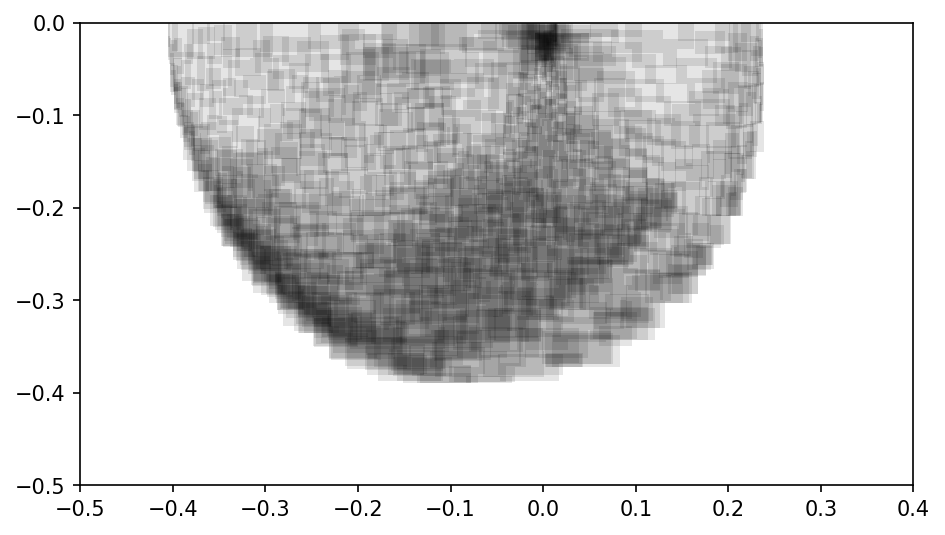

In [24]:
xl = np.array([-.5,.4])
yl = np.array([-.5,0.])

fig = plt.figure(dpi=150)
ax = plt.gca()

#TODO ПОМНИМ ЧТО БЫВАЕТ НАХОДИТ РЕШЕНИЯ В КОРОБКЕ С некоторыми НУЛЕВЫМИ СТОРОНАМИ
x_ind = -2
y_ind = -1

for b in sols:#[::30]:
    # print(b)
    xlb, xub = b[x_ind,0], b[x_ind,1]
    ylb, yub = b[y_ind,0], b[y_ind,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='none',facecolor='k',alpha=.1))

plt.xlim(xl)
plt.ylim(yl)

ax.set_aspect(1)
plt.tight_layout()

plt.show()

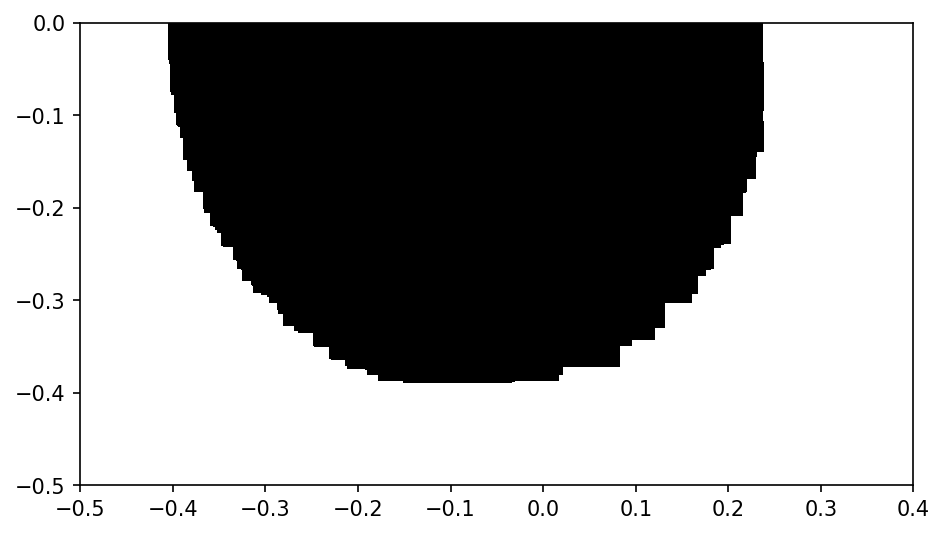

In [25]:
xl = np.array([-.5,.4])
yl = np.array([-.5,0.])

fig = plt.figure(dpi=150)
ax = plt.gca()

#TODO ПОМНИМ ЧТО БЫВАЕТ НАХОДИТ РЕШЕНИЯ В КОРОБКЕ С некоторыми НУЛЕВЫМИ СТОРОНАМИ
x_ind = -2
y_ind = -1

for b in sols:#[::30]:
    # print(b)
    xlb, xub = b[x_ind,0], b[x_ind,1]
    ylb, yub = b[y_ind,0], b[y_ind,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='none',facecolor='k',alpha=1))

plt.xlim(xl)
plt.ylim(yl)

ax.set_aspect(1)
plt.tight_layout()

plt.show()

In [39]:
# inp = sols
# # inp = [np.array([(0,2),(1,3),(-1,2)])]

# positions = np.zeros((len(inp),3)) #[(0,0,0)]
# sizes = np.zeros((len(inp),3)) #[(1,1,1)]

# x_ind = -2
# y_ind = -1
# z_ind = 6

# for i,b in enumerate(inp):
#     # print(b)
#     xlb, xub = b[x_ind,0], b[x_ind,1]
#     ylb, yub = b[y_ind,0], b[y_ind,1]
#     zlb, zub = b[z_ind,0], b[z_ind,1]
#     # print(b[z_ind,:])
#     positions[i,:] = xlb, ylb, zlb
#     sizes[i,:] = xub-xlb, yub-ylb, zub-zlb

# colors = ["crimson"]*len(inp) #,"limegreen" "crimson"
# # colors = [[1.,0.,0.,1.0],[0.,1.,0.,1.]]


# pb = prepare_boxes_plot(positions,sizes,colors=colors, edgecolor='k', alpha=0.2)

# plt.figure(dpi=150)
# plt.subplot(111,projection='3d')
# ax = plt.gca()
# ax.add_collection3d(pb)
 
# ax.set_xlim([-.4,.25])
# ax.set_ylim([-.4,0])
# # ax.set_zlim([-50,100])
# ax.set_zlim([-.25,.1])

# ax.set_aspect('equalxy')
# # ax.set_aspect('equal', adjustable='datalim')

# ax.view_init(elev=30., azim=-55)

# # for ii in xrange(0,360,1):
# #     ax.view_init(elev=10., azim=ii)
# #     savefig("movie%d.png" % ii)

# plt.show()

Второй большой кусок уравнений/неравенств, который по идее должен задавать сингулярные решения, но пока не работает. Можно запустить ниже без него.

**НЕ ОБЯЗАТЕЛЬНО ЗАПУСКАТЬ**

Включает: 
- уравнение суммы твистов от земли до ЕЕ, 
- уравнения сумм твистов по всем независимым лупам
- уравнения для значений компонент единичных твистов для плоского случая, 
- задает единичную норму ненулевого вектора, который после умножения на якобиан дает нуль-вектор

In [13]:
jbranch1 = [0,2,4]#,5]
jsemiloops = [([0,2],[1,3,4])]

# for every independent loop we equalize sum of twists before and after some link
# if loops have common links, we pick first link where they merge to 1 loop
# wj Sj + ... = wk Sk + ...
#sum of twists from ground to EE (T's components are first variables in m where L m=0)   
# T = wj Sj + ...  
# expanded 
# vx = wj sjx + ...
# vy = wj sjy + ...
# w = wj 1 + ...

# m: [vx,vy,w,wi...]
# ms: [vxs,vys,ws,wis...]
# Sj = [sjx,sjy,1] (so omit 1 from vars: [sjx,sjy])   sjx=Pjy sjy=-Pjx (global coords of j-th joint)
# fj = [fjx, fjy]   fjx = sjx wj, fjy = sjy wj

# new X: [m, ms, Sj..., fj,...]

# T path (joints): 1,2
#X: [vx,vy,w,w1,w2, 
#    vxs,vys,ws,w1s,w2s, 
#    s1x,s1y, s2x,s2y,
#    f1x,f1y, f2x,f2y]

# m: [vx,vy,w,wact,wpas...]
# mv: [wact...]
# my: [vx,vy,w,wpas...]

# mu: [vx,vy]  mb with w
# mz: [w,wact,wpas...]

# nj = 2
n_mob = 2
n_loops = len(jsemiloops)
shift = A_eq.shape[1]
q_act_inds = [0,1]  # in q
out_inds = [0,1,2]  # in T
mv_inds = [i+3 for i in q_act_inds]
mu_inds = out_inds

inds_2remove = mu_inds.copy() #TODO input here, and set flag
n_eps = n_mob+nj - 2#len(inds_2remove)
inds_2remove.extend([i+3+nj for i in mu_inds])
# rhs = np.zeros(3+3*n_loops)
# rhs = np.zeros(2)

B2 = np.zeros((2*n_eps+4*nj,2))

#TODO try updating bounds with pow and mul during computation
# (shift+(3-len(out_inds))+ i, shift+2*(n_eps)+ i*2, shift+2*(n_eps)+2*nj+ i*2) # sx triplet (w,sx,fx)
is_rem_out = True
if is_rem_out:
    for i in range(n_eps):
        B2[i,:] = un_b
        B2[i+n_eps,:] = pow_interval(un_b,2)
    for i in range(nj): #intervals for sx, sy and fx, fy
        # good_frame = False
        for j in range(p_i.shape[0]):
            if p_i[j,i,0] is not None:
                # if abs(p_i[j,i,1])<1e-15:
                #     prev = p_i[j,i,:]
                # six = yi = rjy + cj piyj + sj pixj
                B2[2*(n_eps)+ i*2,:] = rb_j[j,1,:] + un_b*p_i[j,i,1] + un_b*p_i[j,i,0]  
                print(i, j, 'sx sum', rb_j[j,1,:], un_b*p_i[j,i,1], un_b*p_i[j,i,0])
                # siy = -xi = -rjx - cj pixj + sj piyj
                B2[2*(n_eps)+1+ i*2,:] = neg_interval(subtr_intervals((rb_j[j,0,:] + un_b*p_i[j,i,0]), un_b*p_i[j,i,1]))
                print('sy sum  -',rb_j[j,0,:],'+',un_b*p_i[j,i,0],'-',un_b*p_i[j,i,1])

                B2[2*(n_eps)+2*nj+ i*2,:] = mul_intervals(un_b, B2[2*(n_eps)+ i*2,:]) #interval w*sx
                B2[2*(n_eps)+2*nj+1+ i*2,:] = mul_intervals(un_b, B2[2*(n_eps)+1+ i*2,:]) #interval w*sy
                break

nvar_2cut = B2.shape[0]
nvar_2 = 2*(3+nj)+4*nj

# A_eqT = np.array([[1,0,0, 0,0, # vx =...
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    -1,0,-1,0], #TODO MB we dont need '-' here and below
#                   [0,1,0, 0,0, # vy =...
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    0,-1,0,-1],
#                   [0,0,1, -1,-1, # w =... 
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    0,0,0,0]])

A_eqT = np.zeros((3+3*n_loops,2*(3+nj)+4*nj))
A_eqT[:3,:3] = -np.eye(3)
for i in jbranch1:
    A_eqT[0,2*(3+nj)+2*nj+ 2*i] = 1
    A_eqT[1,2*(3+nj)+2*nj+ 2*i+1] = 1
    A_eqT[2,3+i] = 1
for row, (sl1,sl2) in enumerate(jsemiloops):
    sl1_x_inds = 2*(3+nj)+2*nj+ 2*np.asarray(sl1)
    sl1_y_inds = 2*(3+nj)+2*nj+ 2*np.asarray(sl1)+1
    sl1_w_inds = 3+np.asarray(sl1)
    sl2_x_inds = 2*(3+nj)+2*nj+ 2*np.asarray(sl2)
    sl2_y_inds = 2*(3+nj)+2*nj+ 2*np.asarray(sl2)+1
    sl2_w_inds = 3+np.asarray(sl2)
    A_eqT[3+row*3,sl1_x_inds] = 1
    A_eqT[3+row*3+1,sl1_y_inds] = 1
    A_eqT[3+row*3+2,sl1_w_inds] = 1
    A_eqT[3+row*3,sl2_x_inds] = -1
    A_eqT[3+row*3+1,sl2_y_inds] = -1
    A_eqT[3+row*3+2,sl2_w_inds] = -1

Lz = A_eqT.copy()
Lz = np.delete(Lz,inds_2remove,1)
### Lz = np.delete(Lz,0,1)
Lz = np.delete(Lz,np.arange(2,Lz.shape[0],3),0)
b_eqT = np.zeros(Lz.shape[0])
print(B2[10:].T)
# print(Lz)
# buf = np.array([i for i in range(12)])
# print(buf[2:len(buf):3])

0 0 sx sum [0.0 0.0] [-0.  0.] [-0.  0.]
sy sum  - [0.0 0.0] + [-0.  0.] - [-0.  0.]
1 0 sx sum [0.0 0.0] [-0.  0.] [ 0.1 -0.1]
sy sum  - [0.0 0.0] + [ 0.1 -0.1] - [-0.  0.]
2 3 sx sum [-1.5 0.0] [-0.209  0.209] [-0.  0.]
sy sum  - [-1.5 1.5] + [-0.  0.] - [-0.209  0.209]
3 1 sx sum [-1.5 0.0] [-0.137  0.137] [-0.  0.]
sy sum  - [-1.5 1.5] + [-0.  0.] - [-0.137  0.137]
4 2 sx sum [-1.5 0.0] [-0.155  0.155] [-0.  0.]
sy sum  - [-1.5 1.5] + [-0.  0.] - [-0.155  0.155]
[[ 0.     0.   ]
 [-0.    -0.   ]
 [ 0.1   -0.1  ]
 [ 0.1   -0.1  ]
 [-1.709  0.209]
 [-1.709  1.709]
 [-1.637  0.137]
 [-1.637  1.637]
 [-1.655  0.155]
 [-1.655  1.655]
 [ 0.     0.   ]
 [-0.    -0.   ]
 [-0.1    0.1  ]
 [-0.1    0.1  ]
 [-1.709  1.709]
 [-1.709  1.709]
 [-1.637  1.637]
 [-1.637  1.637]
 [-1.655  1.655]
 [-1.655  1.655]]


In [14]:
# if Lz.shape[1] != n_eps*2+4*nj: #or Lz.shape[0] != nj:
#     raise ValueError("height of L for non-redundant must be =nj")

#UPD for twist:
# vxs = ry w(1?) + c vxb - s vyb
# vys = -rx w(1?) + c vyb + s vxb
# w = w

A_eqS = np.zeros((2*nj,nvar_1+nvar_2))
b_eqS = np.zeros(2*nj)

if is_rem_out:
    # for i in range(n_eps):
    #     B2[i,:] = un_b
    #     B2[i+n_eps,:] = pow_interval(un_b,2)
    for i in range(nj):
        for j in range(p_i.shape[0]):
            if p_i[j,i,0] is not None:
                # print(j,i)
                A_eqS[2*i,shift+2*(3+nj)+ i*2] = -1 # sx
                A_eqS[2*i+1,shift+2*(3+nj)+1+ i*2] = -1 # sy
                if j>0:
                    A_eqS[2*i,w*(j-1)+1] = 1
                    A_eqS[2*i,w*(j-1)+2] = -p_i[j,i,1] # cos

                    
                    A_eqS[2*i+1,w*(j-1)] = -1

                    A_eqS[2*i+1,w*(j-1)+3] = -p_i[j,i,1] # sin
                else:
                    b_eqS[2*i] = p_i[j,i,1]
                break

# A_eqS = np.array([[0,1,p1y1,p1x1,0,0, # s1x
#                     0,0,0,0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     -1,0,0,0,
#                     0,0,0,0],
#                     [-1,0,-p1x1,p1y1,0,0, # s1y
#                     0,0,0,0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     0,-1,0,0,
#                     0,0,0,0],
#                   [0,0,0,0,0,0, # s2x
#                   0,1,p2y2,p2x2,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,-1,0,
#                   0,0,0,0],
#                   [0,0,0,0,0,0, # s2y
#                   -1,0,-p2x2,p2y2,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,0,-1,
#                   0,0,0,0]])
A_eqSz = A_eqS.copy()
A_eqSz = np.delete(A_eqSz,[i+shift for i in inds_2remove], 1)


# ([0-p1y0,0+p1x0, # zeros because r0 = [0,0] for any mechanism. 
# ,0,0])
# b_eqS = np.array([0,0,
#                   0,0])

# print(A_eqSz)
eps_length = 1.
# A_eq_eps = np.array([[0,0,0, 0,0, # vector m is not zero
#                       1,1,1, 1,1,
#                       0,0,0,0,
#                       0,0,0,0]])

A_eq_eps = np.zeros((1,nvar_2))
A_eq_eps[0,3+nj:2*(3+nj)] = 1

A_eq_epsz = A_eq_eps.copy()
A_eq_epsz = np.delete(A_eq_epsz,inds_2remove,1)
# print(A_eq_epsz)

b_eq_eps = np.array([eps_length])

# m_length_lb = 0.01
# A_ub_m = np.array([[0,0,0, 0,0, # vector m is not zero
#                    -1,-1,-1, -1,-1,
#                    0,0,0,0,
#                    0,0,0,0]])
# b_ub_m = np.array([-m_length_lb])


# [0,0,0,0,0,0, # s1x simpler because in 0 frame
# 0,0,0,0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,0,0, 0,0,
# -1,0,0,0,
# 0,0,0,0],
# [0,0,0,0,0,0, # s1y simpler because in 0 frame
# 0,0,0,0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,-1,0,0,
# 0,0,0,0],

for i in range(n_eps):
    sqr_pairs.append((shift+i, shift+n_eps+i))

# indexes for hyperbolic terms
#wi = shift + 3 + j_ind                  (starting from 0) #works for full L and m #TODO fix for deleting wis
#six = shift + 2*(3+nj) + j_ind*nj
#siy = shift + 2*(3+nj) + j_ind*nj + 1
#fix = shift + 2*(3+nj) + 2*nj + j_ind*nj
#fiy = shift + 2*(3+nj) + 2*nj + j_ind*nj + 1


# cross_triplets = [(shift+3+ 0, shift+2*(3+nj)+ 0*nj, shift+2*(3+nj)+2*nj+ 0*nj), #j1   w sx
#                   (shift+3+ 0, shift+2*(3+nj)+1+ 0*nj, shift+2*(3+nj)+2*nj+1+ 0*nj), # w sy
#                   (shift+3+ 1, shift+2*(3+nj)+ 1*nj, shift+2*(3+nj)+2*nj+ 1*nj), #j2   w sx
#                   (shift+3+ 1, shift+2*(3+nj)+1+ 1*nj, shift+2*(3+nj)+2*nj+1+ 1*nj), # w sy
#                   ]
if is_rem_out:
    for i in range(nj):
        cross_triplets.append((shift+ i, shift+2*(n_eps)+ i*2, shift+2*(n_eps)+2*nj+ i*2))
        cross_triplets.append((shift+ i, shift+2*(n_eps)+1+ i*2, shift+2*(n_eps)+2*nj+1+ i*2))
# print(A_eq)

# for i in range(4,12):
#     B2[i,:] = np.array([-1.5,1.5])
B_merg = np.vstack((B,B2))
A_eq_merg = np.vstack((np.hstack((A_eq, np.zeros((A_eq.shape[0],Lz.shape[1])))),
                       np.hstack((np.zeros((Lz.shape[0],shift)),Lz)),
                       A_eqSz,
                       np.hstack((np.zeros((A_eq_epsz.shape[0],shift)),A_eq_epsz))
                       ))
# print(Lz)
# print(A_eq_epsz)
# print(cross_triplets)
# print(sqr_pairs)
# print(A_eq_epsz)
b_eq_merg = np.concatenate((b_eq,b_eqT,b_eqS,b_eq_eps))

# print(B2)
# print((B[:,1]-B[:,0]).T)

Запускаем полную проблему по сингулярностям (пока не работает)

In [ ]:
threshold_s = B_merg[:,1]-B_merg[:,0]
threshold_s[(shift-2,shift-1),] /= 4

P=[B_merg]
# sols = box_serial(P, A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s)
solsS = box_parallel(P, A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s,n_processes=3,batch=10000)
# sols = approximate_boxes(B_merg, A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s)


-------------------
unexplored: 1
unexplored: 0
Search took 2.569 seconds
-------------------
unexplored: 0
solutions: 0
